In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pysta
import stc

import os

%load_ext autoreload
%autoreload 2

# run for all cells (OFF LINE)

run 
```
python3 stcl_batch.py [DATASET] --dim D
```

datasets
* 20180618
* 20180621
* 20180626
* 20180828

## load stim and spike data

In [2]:
folder_name = "data"

#dataset_name = "20180618"
#dataset_name = "20180621"
dataset_name = "20180626"
# dataset_name = "20180828"

stim, spike_train, info = pysta.load_data(dataset_name, folder_name)

# channel_names = [ch.replace("ch_","") for ch in info["channel_names"]]   # NOT NEEDED ANYMORE
# info["channel_names"]
# info["cell_types"]


['dataset_name', 'stim', 'spike_train', 'info']
(64, 9000)
(156, 9000)
{'channel_names': ['12a', '12b', '12c', '13a', '13b', '13c', '13d', '13e', '14a', '14b', '14c', '14d', '16a', '16b', '16c', '17a', '17b', '17c', '17d', '21a', '21b', '21c', '21d', '21e', '22a', '22b', '23a', '23b', '23c', '23d', '25a', '25b', '25c', '26a', '26b', '26c', '26d', '27a', '27b', '27c', '27d', '28a', '28b', '28c', '31a', '31b', '31c', '31d', '32a', '32b', '32c', '33a', '33b', '33c', '33d', '35a', '35b', '35c', '35d', '35e', '35f', '35g', '36a', '36b', '36c', '36d', '37a', '37b', '37c', '37d', '37e', '38a', '41a', '41b', '41c', '41d', '42a', '42b', '42c', '43a', '43b', '43c', '45a', '45b', '45c', '46a', '46b', '47a', '48a', '48b', '48c', '48d', '48e', '51a', '51b', '53a', '53b', '53c', '53d', '54a', '54b', '54c', '54d', '56a', '56b', '58a', '61a', '61b', '62a', '62b', '63a', '63b', '63c', '63d', '63e', '64a', '65a', '65b', '65c', '68a', '68b', '71a', '71b', '71c', '72a', '72b', '72c', '72d', '72e', '73a', 

In [3]:
# calc number of spikes
tap = 8 # -700 ms ~ 0

num_samples = list()
for idx in range(spike_train.shape[0]):    
    spike_triggered_stim, spike_count = pysta.grab_spike_triggered_stim(stim, spike_train[idx], tap)
    num_samples.append(spike_triggered_stim.shape[0])

num_samples_df = pd.DataFrame({"channel_name": info["channel_names"], "number_of_samples": num_samples})
# num_samples_df

## read clustering results (dim=1)

In [ ]:
dim = 1
folder_name = "{}_tap{}_stc_classic_cluster_dim{}".format(dataset_name, tap, dim)
filename = os.path.join(folder_name, "clusters.csv")

clusters = pd.read_csv(filename)
# weights
# weights.head()

clusters["max_weight"] = np.maximum(clusters["weight1"], clusters["weight2"])

clusters = clusters.merge(num_samples_df, on="channel_name") #, how="outer")

filename = os.path.join(folder_name, "clusters_combined.csv")
clusters.to_csv(filename, index=None)

In [ ]:
clusters_with_negative_inner_product = clusters.loc[clusters["inner_product"]<0,:]

print(len(clusters_with_negative_inner_product), len(clusters))
clusters_with_negative_inner_product

In [ ]:
bins = np.linspace(0.5, 1, 20)
plt.hist(clusters["max_weight"], bins=bins)
#clusters["max_weight"].hist()
#plt.
plt.savefig("{}/max_weight_hist.png".format(folder_name))

In [ ]:
clusters["inner_product"].hist()
plt.savefig("{}/inner_product_hist.png".format(folder_name))

## clustering with 2 dim

In [4]:
dim = 2
folder_name = "{}_tap{}_stc_classic_cluster_dim{}".format(dataset_name, tap, dim)
filename = os.path.join(folder_name, "clusters.csv")

clusters_dim2 = pd.read_csv(filename)
# weights
# weights.head()

clusters_dim2["max_weight"] = np.maximum(clusters_dim2["weight1"], clusters_dim2["weight2"])

clusters_dim2 = clusters_dim2.merge(num_samples_df, on="channel_name") #, how="outer")

filename = os.path.join(folder_name, "clusters_combined.csv")
clusters_dim2.to_csv(filename, index=None)

In [6]:
clusters_with_negative_inner_product_dim2 = clusters_dim2.loc[clusters_dim2["inner_product"]<0,:]

print(len(clusters_with_negative_inner_product_dim2), len(clusters_dim2))
clusters_with_negative_inner_product_dim2

118 156


,channel_name,weight1,weight2,inner_product,max_weight,number_of_samples
0,12a,0.474547,0.525453,-0.131497,0.525453,2868
1,12b,0.472841,0.527159,-0.100928,0.527159,1123
3,13a,0.494100,0.505900,-0.202205,0.505900,6610
6,13d,0.503472,0.496528,-0.317902,0.503472,288
7,13e,0.491071,0.508929,-0.212121,0.508929,112
...,...,...,...,...,...,...
150,86b,0.466216,0.533784,-0.310025,0.533784,1332
151,86c,0.500000,0.500000,-0.218429,0.500000,526
152,86d,0.503356,0.496644,-0.124781,0.503356,149
154,87b,0.488041,0.511959,-0.117703,0.511959,3512


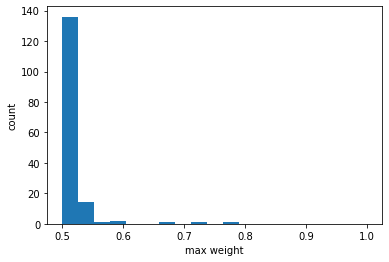

In [7]:
bins = np.linspace(0.5, 1, 20)
plt.hist(clusters_dim2["max_weight"], bins=bins)
plt.xlabel("max weight")
plt.ylabel("count")
#clusters["max_weight"].hist()
#plt.
plt.savefig("{}/max_weight_hist.png".format(folder_name))

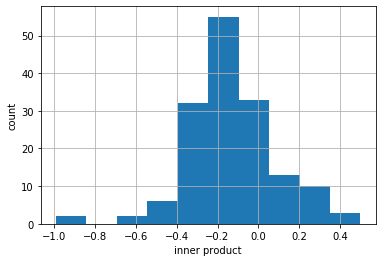

In [8]:
clusters_dim2["inner_product"].hist()
plt.xlabel("inner product")
plt.ylabel("count")
plt.savefig("{}/inner_product_hist.png".format(folder_name))

## clustering with 3 dim

In [ ]:
dim = 3
folder_name = "{}_tap{}_stc_classic_cluster_dim{}".format(dataset_name, tap, dim)

filename = os.path.join(folder_name, "clusters.csv")

clusters = pd.read_csv(filename)
# weights
# weights.head()

clusters["max_weight"] = np.maximum(clusters["weight1"], clusters["weight2"])

clusters = clusters.merge(num_samples_df, on="channel_name") #, how="outer")

filename = os.path.join(folder_name, "clusters_combined.csv")
clusters.to_csv(filename, index=None)

In [ ]:
clusters_with_negative_inner_product = clusters.loc[clusters["inner_product"]<0,:]

print(len(clusters_with_negative_inner_product), len(clusters))
clusters_with_negative_inner_product

In [ ]:
bins = np.linspace(0.5, 1, 20)
plt.hist(clusters["max_weight"], bins=bins)
#clusters["max_weight"].hist()
#plt.
plt.savefig("{}/max_weight_hist.png".format(folder_name))

In [ ]:
clusters["inner_product"].hist()
plt.savefig("{}/inner_product_hist.png".format(folder_name))

## paired t-test

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html

In [10]:
from scipy import stats

In [15]:
stats.ttest_rel(clusters_dim2["max_weight"], clusters_dim2["max_weight"])

Ttest_relResult(statistic=nan, pvalue=nan)

In [12]:
stats.ttest_rel(clusters_dim2["inner_product"], clusters_dim2["inner_product"])

Ttest_relResult(statistic=nan, pvalue=nan)